In [ ]:
import datetime as dt
import pandas as pd
from matplotlib import pyplot as plt
import utils
from scipy.optimize import minimize
import numpy as np

## Reading in Data

In [25]:
# Reading in the dataframe and converting to dates and floats
btc_df = pd.read_csv("Data.csv", index_col=0, parse_dates=True)
btc_df["price"] = btc_df["price"].str.replace(",", "").astype(float)
btc_df["price_diff"] = btc_df["price"] - btc_df["price"].shift(1)
btc_ar = btc_df.values

# Verifying that no days are missing in the model
assert all(btc_df.index.to_series() == pd.date_range(start="2020-04-25", end="2025-10-15"))

In [30]:
def get_df():
    # A function that returns the bitcoin dataframe
    btc_df = pd.read_csv("Data.csv", index_col=0, parse_dates=True)
    btc_df["price"] = btc_df["price"].str.replace(",", "").astype(float)
    btc_df["price_diff"] = btc_df["price"] - btc_df["price"].shift(1)
    return btc_df

## First Autoregressive Model Experiment

Here we'll try to model the future price based on two days; one from a week ago and one from a month ago.

In [26]:
def build_guess_column(params, df, shifts, col_name="price", est_name="estimation_column"):
    """
    Adds a new column to the input dataframe that builds the estimated values out of linear transformations of shifted columns.
    """
    df = df.copy()
    df[est_name] = sum([params[i] * df[col_name].shift(shift) for i, shift in enumerate(shifts)])
    return df

In [27]:
def compute_loss(params, df, shifts, col_name="price", est_name="estimation_column"):
    """
    Computes the loss for a guess. Uses mean-squares as the loss function.
    """
    est_df = build_guess_column(params, df, shifts, col_name=col_name, est_name=est_name)
    diff = (est_df[col_name] - est_df[est_name])**2
    return diff.sum()

Optimal exposures: [ 9.47968367e-01  6.64028361e-02  5.79008428e-03 -2.71816842e-03
  1.04620892e-02 -2.36729247e-02 -1.55640156e-02 -4.75598596e-02
  9.94382004e-02 -2.11569751e-02  5.44086205e-03 -6.67690965e-02
  8.79174935e-02 -2.80784081e-02 -3.92850368e-02 -4.78485181e-03
  4.12021503e-02 -3.04876293e-02 -2.25345902e-02  2.37396305e-02
  1.26301356e-02 -3.33193388e-03 -3.15317018e-02  8.16292573e-02
 -8.32129645e-04 -2.11490465e-02  3.67545442e-02  4.48897926e-03
 -6.45048107e-02]
Optimal loss:      2584791495.1319637


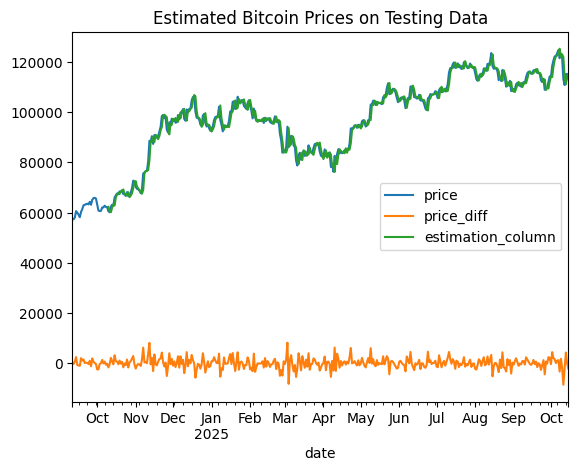

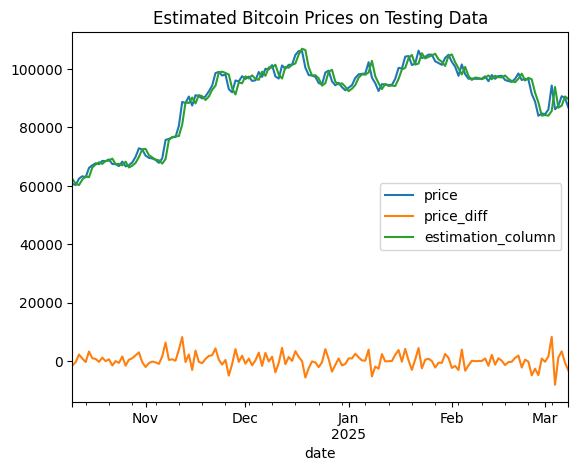

In [28]:
# Making a train-test split
n = len(btc_df)
btc_df_train, btc_df_test = btc_df.iloc[:int(0.8*n)], btc_df.iloc[int(0.8*n):]

# Training the coefficients
shifts = list(range(1, 30, 1))
x0 = [1 for _ in range(len(shifts))]
result = minimize(compute_loss, x0, args=(btc_df_train, shifts))

print(f"Optimal exposures: {result.x}")
print(f"Optimal loss:      {result.fun}")

# Graphing the daily guesses
params = result.x

est_df = build_guess_column(params, btc_df_test, shifts)
est_df.plot()
plt.title("Estimated Bitcoin Prices on Testing Data")
plt.show()

est_df.iloc[max(shifts):max(shifts) + 150].plot()
plt.title("Estimated Bitcoin Prices on Testing Data")
plt.show()

## Experimenting on daily returns instead of daily prices

Optimal exposures: [-0.0476226   0.01904798  0.01607154  0.01446489  0.03514896  0.0010223
 -0.01578266 -0.04740604  0.03943848  0.02097644  0.02856903 -0.03905973
  0.03901863  0.01919238 -0.02548147 -0.03601906  0.01348599 -0.00949376
 -0.04032987 -0.01356323  0.01100416 -0.00582389 -0.03724618  0.04864776
  0.05354951  0.0150743   0.05905635  0.06180662 -0.0313701  -0.02525445
  0.03135662 -0.01744142  0.05928894 -0.00916112 -0.00661902 -0.04429662
  0.00792066 -0.03762994  0.00032446  0.06763904 -0.02462339 -0.00807353
  0.04772182  0.04783929 -0.04053758 -0.04746163 -0.00041763 -0.0008623
 -0.04094876  0.02389658 -0.02017878 -0.01139322  0.01093176  0.01549699
  0.01396614  0.04607051  0.01948144  0.02922049  0.01586467]
Optimal loss:      2507056481.8093104


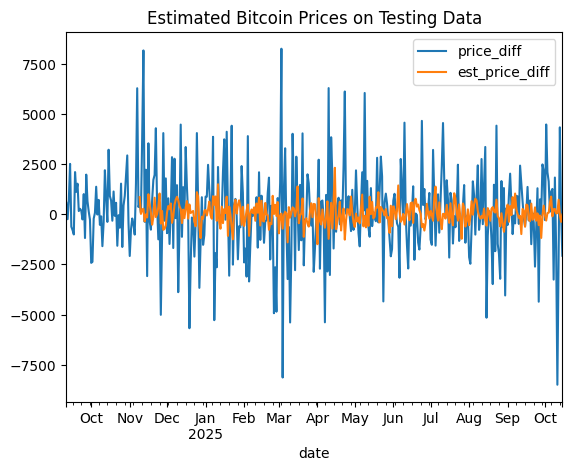

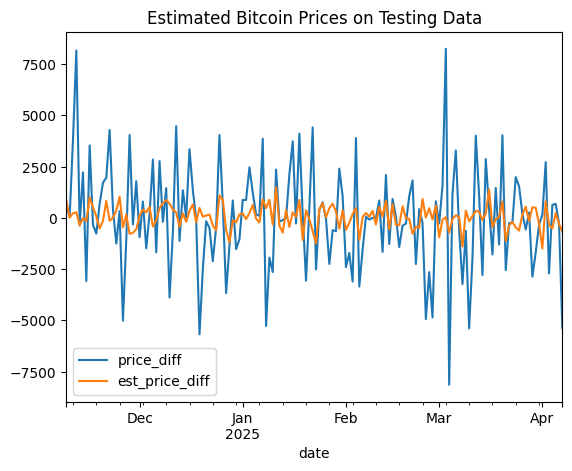

In [42]:
# Making a returns df
ret_df = get_df()
ret_df.drop(columns="price", inplace=True)

# Making a train-test split
n = len(ret_df)
ret_df_train, ret_df_test = ret_df.iloc[:int(0.8*n)], ret_df.iloc[int(0.8*n):]

# Training the coefficients
shifts = list(range(1, 60, 1))
x0 = [1 for _ in range(len(shifts))]
result = minimize(compute_loss, x0, args=(ret_df_train, shifts, "price_diff", "est_price_diff"))

print(f"Optimal exposures: {result.x}")
print(f"Optimal loss:      {result.fun}")

# Graphing the daily guesses
params = result.x

est_df = build_guess_column(params, ret_df_test, shifts, "price_diff", "est_price_diff")
est_df.plot()
plt.title("Estimated Bitcoin Prices on Testing Data")
plt.show()

est_df.iloc[max(shifts):max(shifts) + 150].plot()
plt.title("Estimated Bitcoin Prices on Testing Data")
plt.show()